In [1]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import nglview as ngl
%matplotlib inline

## Read in the MD trajectory

Below we read in the production simulation trajectory using the topology available in the PDB file of the starting structure.

In [2]:
traj = md.load('ethane_sim.dcd', top='ethane.pdb')
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,ETH,0,
1,2,H11,H,1,ETH,0,
2,3,H12,H,1,ETH,0,
3,4,H13,H,1,ETH,0,
4,5,C2,C,1,ETH,0,
5,6,H21,H,1,ETH,0,
6,7,H22,H,1,ETH,0,
7,8,H23,H,1,ETH,0,


## Analyzing the H-C-C-H torsion

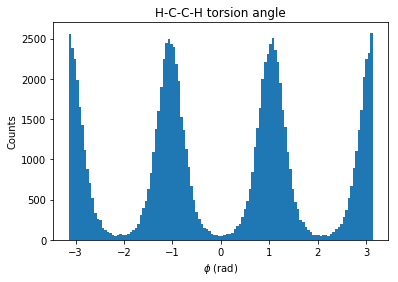

In [3]:
phi_indices = [1, 0, 4, 5] # atoms to define the torsion angle
phi = md.compute_dihedrals(traj, [phi_indices])

phicounts, binedges, otherstuff = plt.hist(phi, bins=120) # create a histogram with 90 bins
plt.title('H-C-C-H torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

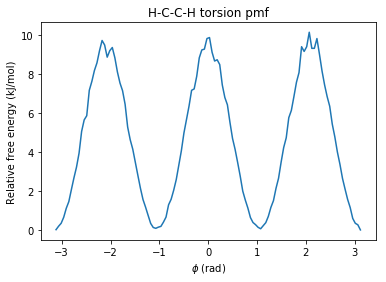

In [4]:
kB = 8.31446/1000 # Boltzmann constant in kcal/mol
Temp = 298.15 # simulation temperature
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('H-C-C-H torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

This pmf isn't very smooth – especially near the free energy maxima – due to the finite sampling inherent to our relatively short simulation.  Let's try to smooth it out using the LOWESS (locally weighted scatterplot smoothing) algorithm:

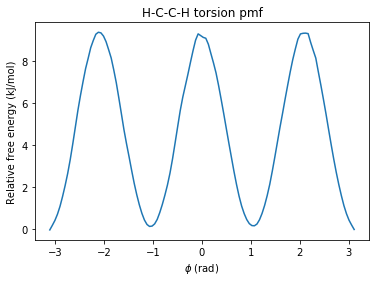

In [5]:
pmf_smoothed = sm.nonparametric.lowess(pmf, bincenters, frac=0.05)
plt.plot(pmf_smoothed[:,0], pmf_smoothed[:,1])
plt.title('H-C-C-H torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

Overall this matches our expectation for rotating ethane about the C-C bond: there should be three identical minima and maxima corresponding to the H atoms being staggered or overlapped, respectively.

## Analyzing the C-C bond length

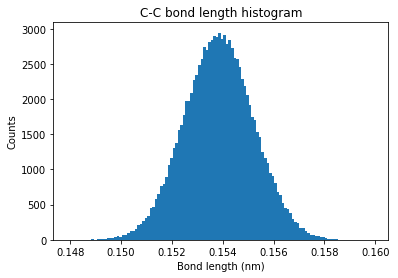

In [14]:
bond_indices = [0, 4] # atoms to define the bond length
bondlength = md.compute_distances(traj, [bond_indices])

bondcounts, binedges, otherstuff = plt.hist(bondlength, bins=120)
plt.title('C-C bond length histogram')
plt.xlabel('Bond length (nm)')
plt.ylabel('Counts')
plt.show()

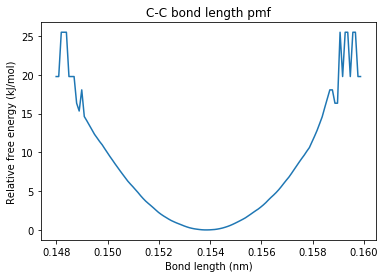

In [15]:
bondcounts[bondcounts==0] = 0.1
pmf = -kB*Temp*np.log(bondcounts)
pmf = pmf - np.min(pmf)

bincenters = (binedges[1:] + binedges[:-1])/2

pmf_smoothed = sm.nonparametric.lowess(pmf, bincenters, frac=0.05)
pmf_s = pmf_smoothed[:,1] - np.min(pmf_smoothed[:,1])

plt.plot(bincenters, pmf_s)
plt.xlabel('Bond length (nm)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.title('C-C bond length pmf')
plt.show()

The curve looks a bit jagged for the high energy regions of the pmf, mainly due to the lack of statistics accumulated there. Let's make a plot that includes only bond lengths with a relative free energy of <15 kJ/mol using Python's subsetting ability.

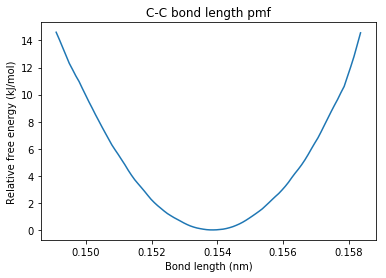

In [16]:
plt.plot(bincenters[pmf_s < 15], pmf_s[pmf_s < 15])
plt.xlabel('Bond length (nm)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.title('C-C bond length pmf')
plt.show()

This looks pretty good!  We see that the pmf for the C-C bond length is parabolic, which reflects the underlying harmonic potential for the C-C bond.

## Visualizing the trajectory using NGLview

In [10]:
visualize = ngl.show_mdtraj(traj)
visualize

NGLWidget(count=100000)